In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_gen_uniq = pd.read_csv('dados/generos_uniq.csv',sep=';')
df_gen_uniq.head()

,titulo,generos
0,Good Omens,Fantasia
1,The Office,Comedia
2,Friends,Comedia
3,The Big Bang Theory,Comedia
4,How I Met Your Mother,Comedia


In [3]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))

pathlib.Path(f'img_data').mkdir(parents=True, exist_ok=True)
for filename in os.listdir('dados/audio'):
    songname = f'dados/audio/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'img_data/{filename[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 576x576 with 0 Axes>

In [4]:
header = 'filename chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [5]:
#Somente um genêro por música
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
for filename in os.listdir('dados/audio'):
    songname = f'dados/audio/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    rmse = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename};{np.mean(chroma_stft)};{np.mean(rmse)};{np.mean(spec_cent)};{np.mean(spec_bw)};{np.mean(rolloff)};{np.mean(zcr)}'    
    for e in mfcc:
        to_append += f';{np.mean(e)}'
    g = df_gen_uniq[df_gen_uniq['titulo'] == f'{filename[:-4]}']['generos'].values[0]
    to_append += f';{g}'
    file = open('dataset.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split(';'))

In [6]:
data = pd.read_csv('dataset.csv')
data = data.drop(['filename'],axis=1)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Visualizações

In [7]:
data.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.287795,0.021674,1664.240929,1693.963405,3013.956916,0.090801,-341.899139,119.685440,-34.954018,11.715201,...,5.826225,-2.281594,-5.188182,-13.350756,-7.033623,-9.396832,-0.197803,-2.072901,0.040063,Drama
1,0.413944,0.067197,2545.131551,2215.134433,4960.630483,0.158011,-158.506485,84.686523,-25.399679,40.830395,...,5.413409,0.589826,7.061391,-3.843799,5.968225,-5.008075,-5.870964,-3.267418,0.310933,Comedia
2,0.341159,0.111057,2631.166231,2570.767108,5726.216191,0.131315,-94.546257,77.893372,0.659534,24.779293,...,4.786926,-6.667707,3.762797,-4.380331,4.313585,-3.959847,3.780821,-3.552129,4.660139,Acao
3,0.578228,0.078024,1272.997641,1605.714025,2551.446634,0.059756,-205.367950,158.147125,-18.372679,11.182042,...,2.328150,2.469501,11.824834,-1.149633,1.142855,-2.509918,2.044632,-6.174470,4.305695,Drama
4,0.346377,0.070298,1211.087739,1507.847551,2302.344411,0.060020,-234.199158,150.023636,-17.067760,28.260141,...,5.218316,-3.649328,0.720676,-1.759529,5.930017,-0.732975,6.087806,3.585165,4.832595,Terror


In [8]:
gens = np.unique(data['label'].values)
n_gens = len(gens)
colors = ['#001219', '#005f73', '#0a9396', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012']

Text(0.5, 1.0, 'Chroma por gênero')

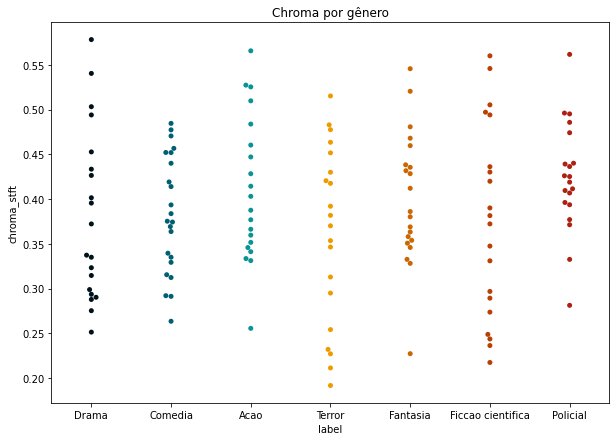

In [9]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='chroma_stft', data=data, dodge=True, palette=colors)
plt.title("Chroma por gênero")

Text(0.5, 1.0, 'Chroma por gênero')

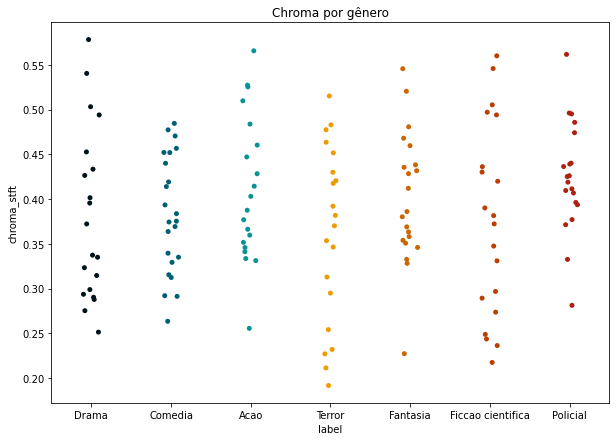

In [10]:
plt.figure(figsize=(10,7))
sns.stripplot(x='label', y='chroma_stft', data=data, dodge=True, palette=colors)
plt.title("Chroma por gênero")

Text(0.5, 1.0, 'Raiz quadrada média do erro por gênero')

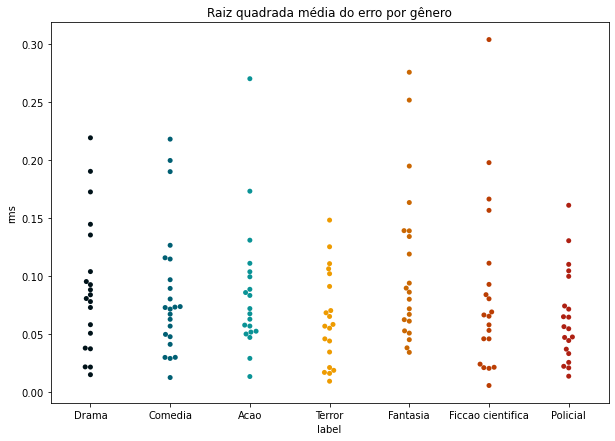

In [11]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='rms', data=data, dodge=True, palette=colors)
plt.title("Raiz quadrada média do erro por gênero")

Text(0.5, 1.0, 'Centróide espectral por gênero')

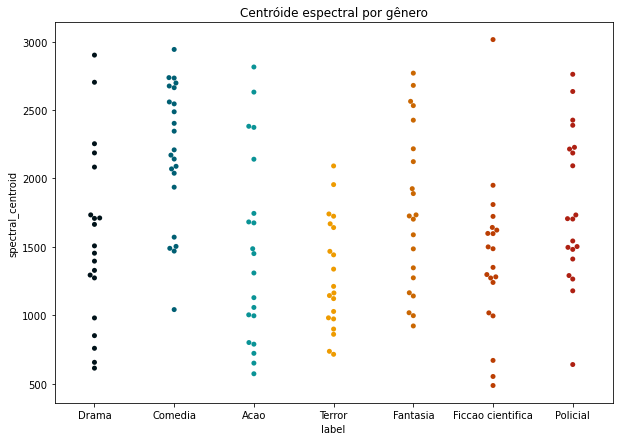

In [12]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='spectral_centroid', data=data, dodge=True, palette=colors)
plt.title("Centróide espectral por gênero")

Text(0.5, 1.0, 'Largura de banda espectral por gênero')

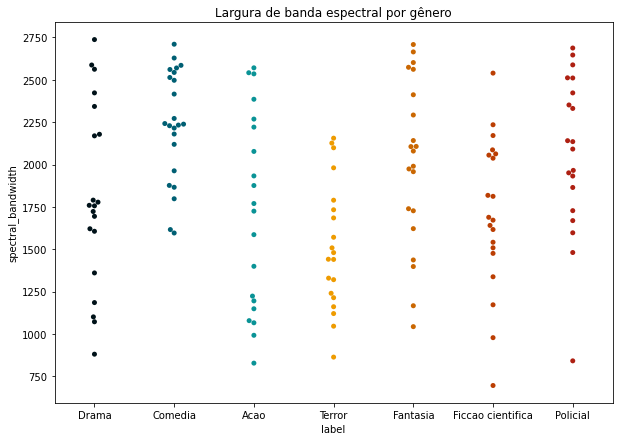

In [13]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='spectral_bandwidth', data=data, dodge=True, palette=colors)
plt.title("Largura de banda espectral por gênero")

Text(0.5, 1.0, 'Roll-off por gênero')

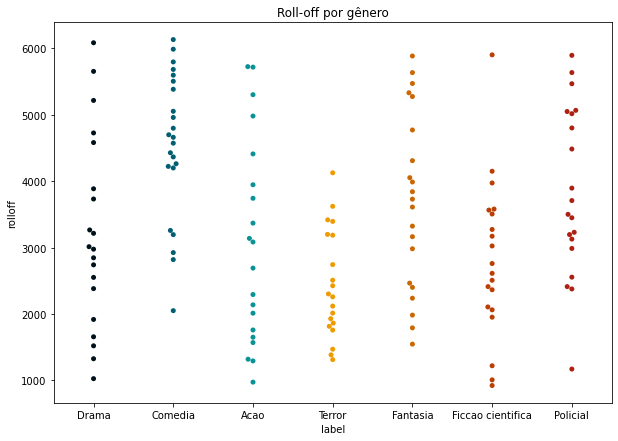

In [14]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='rolloff', data=data, dodge=True, palette=colors)
plt.title("Roll-off por gênero")

Text(0.5, 1.0, 'Taxa de cruzamento do zero por gênero')

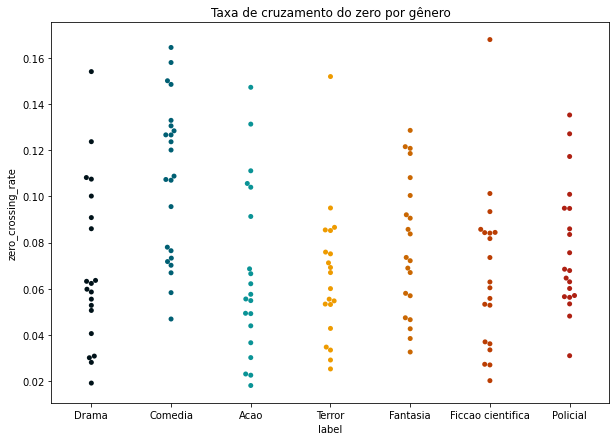

In [15]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='zero_crossing_rate', data=data, dodge=True, palette=colors)
plt.title("Taxa de cruzamento do zero por gênero")

In [16]:
data['mfcc_m'] = data[['mfcc1','mfcc2','mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10',
                       'mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16','mfcc17','mfcc18','mfcc19','mfcc20']].mean(axis=1)

Text(0.5, 1.0, 'Média do cepstrum de frequência de mel por gênero')

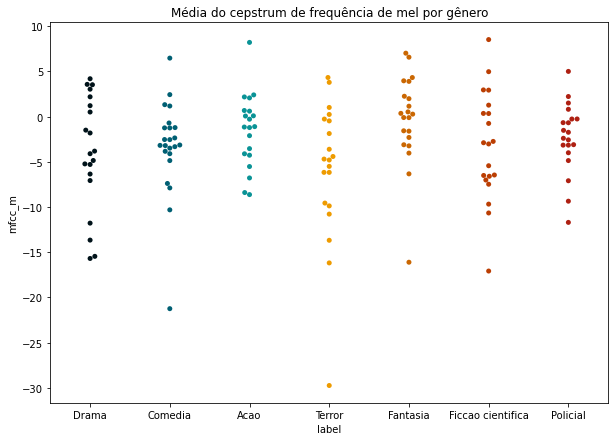

In [17]:
plt.figure(figsize=(10,7))
sns.swarmplot(x='label', y='mfcc_m', data=data, dodge=True, palette=colors)
plt.title("Média do cepstrum de frequência de mel por gênero")

# Classificadores
## ANN

In [18]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
1/1 [==============================] - 0s 414ms/step - loss: 2.2842 - accuracy: 0.1304
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 2.1971 - accuracy: 0.2261
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 2.1218 - accuracy: 0.2435
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 2.0548 - accuracy: 0.3130
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 1.9908 - accuracy: 0.3478
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 1.9292 - accuracy: 0.4000
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8696 - accuracy: 0.4174
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 1.8112 - accuracy: 0.4435
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7533 - accuracy: 0.4609
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6954 - accuracy: 0.4696
Epoch 11/100
1/1 [=========

1/1 [==============================] - 0s 4ms/step - loss: 0.0120 - accuracy: 1.0000
Epoch 85/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 1.0000
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 87/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 88/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 90/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0093 - accuracy: 1.0000
Epoch 91/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0090 - accuracy: 1.0000
Epoch 92/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 93/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 94/100
1/1 [===============

## KNN

In [20]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
cat = pd.Categorical(data['label'])
scaler = preprocessing.StandardScaler()
Z_train = scaler.fit_transform(X_train)

model = KNeighborsClassifier()
model = model.fit(Z_train, y_train)

Z_test = scaler.transform(X_test)
model.predict(Z_test)


array([3, 2, 4, 4, 4, 1, 6, 1, 0, 4, 3, 3, 6, 0, 2, 3, 1, 2, 2, 3, 1, 4,
       5, 6, 4, 1, 4, 0, 6])

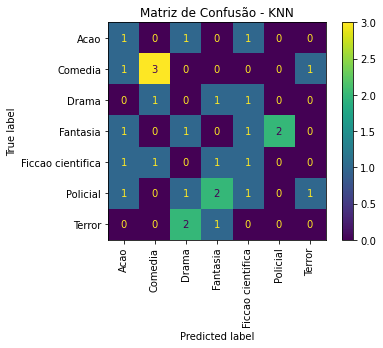

In [21]:
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - KNN')
plt.xticks([0, 1, 2, 3, 4, 5, 6,], cat.categories, rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6], cat.categories);

## LR

[1 4 1 6 2 1 6 2 4 4 6 3 6 0 6 5 6 2 4 5 1 4 2 0 4 1 6 1 2]


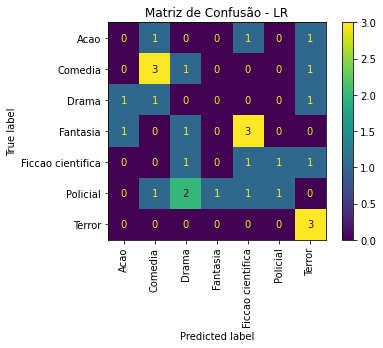

In [22]:
from sklearn.linear_model import LogisticRegressionCV
model_lr = LogisticRegressionCV()
model_lr = model_lr.fit(X_train, y_train)
print(model_lr.predict(X_test))

cm = confusion_matrix(y_test, model_lr.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - LR')
plt.xticks([0, 1, 2, 3, 4, 5, 6], cat.categories, rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6], cat.categories);

## SVC

[1 0 2 2 2 1 2 1 2 4 5 3 6 0 2 5 6 6 4 5 1 3 5 6 4 1 6 1 6]


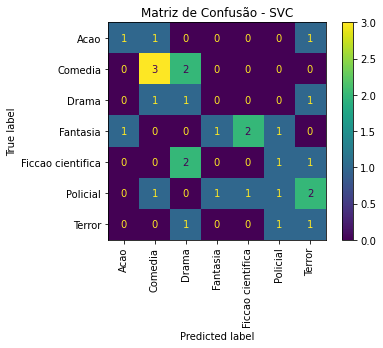

In [23]:
from sklearn.svm import SVC
model_svc = SVC()
model_svc = model_svc.fit(X_train, y_train)
print(model_svc.predict(X_test))

cm = confusion_matrix(y_test, model_svc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Matriz de Confusão - SVC')
plt.xticks([0, 1, 2, 3, 4, 5, 6], cat.categories, rotation=90)
plt.yticks([0, 1, 2, 3, 4, 5, 6], cat.categories);

In [24]:
gens = np.unique(df_gen_uniq['generos'].values)
for g in gens:
    print(g, len(df_gen_uniq[df_gen_uniq['generos'] == g]))

Acao 20
Comedia 23
Drama 20
Fantasia 21
Ficcao cientifica 20
Policial 20
Terror 20
